# Petrophysical Properties regression (Random Forest) using elastic properties.

* **Autor:** Rodrigo Lopez Aburto
* **Versión:** 1.0
* **Fecha:** Diciembre 2023

## Summary

The present NoteBook follows the data preparation, training, testing and implementation of Random Forest methods for the prediction of Petrophysical properties using well logs. Well logs data, petrophysical classes and user-defined functions are loaded into the NoteBook; exploratory data analysis is conducted in three stages, aiming to ensure quality and identify data characteristics.

Data standardisation was conducted before the data set splitting process; four different Random Forest algorithms were trained and tuned using the Petrophysical classes estimated during the clustering analysis process to control and subdivide the regression process into four models, each aimed to estimate the total porosity in each one of the petrophysical classes.

Once the regressors have been trained, validation is conducted using data from new wells with known properties to demonstrate the quality of the regression and provide metrics for each of the well's predictions.

### Libraries

In [1]:
## Standard Libraries.
import os
import time
import numpy as np
import pandas as pd
from scipy.stats import mode
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from scipy.stats import pearsonr

## Data visualization libraries.
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.image as image
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

## Data science libraries.
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Random forest libraries.
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

## Metric libraries.
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

**Functions**

In [2]:
from Funciones.GraphStat import *
from Funciones.RF_Batch import *

### Data import.

Data from 19 wells was loaded (well logs, petrophysical properties and petrophysical classes) into a pd.DataFrame. Additionally, well-head locations were loaded; these were necessary to conduct the spatial statistical analysis.

In [3]:
Loaded_Data = ['Well_ID','DEPT','Vp','Vs','VpVs','RelPoisson','K','mu','IAP','IAS',
               'RHOZ','E','lambda','mu_rho','lambda_rho','PoroFluido','Electrofacies_Class']
Elastic_logs = ['Vp','Vs','VpVs','RelPoisson','K','mu','E','lambda','IAP','IAS','RHOZ','mu_rho','lambda_rho']
petrophysic_properties = ['PoroFluido']

In [4]:
currdir = os.getcwd()
df_CHTC = pd.read_csv(currdir + '\\Datos\\Electrofacies_Predicted.csv', 
                            usecols=Loaded_Data, low_memory=False, na_values=-999.25)
df_CHTC.dropna(axis=0, inplace=True)
df_WellHeads = pd.read_csv(currdir + '\\Datos\\Well_Heads.csv', low_memory=False, na_values=-999.25)

In [5]:
print('%i samples were loaded' %df_CHTC.shape[0])

55371 samples were loaded


In [6]:
pd.options.display.float_format = '{:.5f}'.format

In [7]:
Target_log = 'PoroFluido'

## Exploratory analysis.

Aiming to understand better the behaviour and relationships between the well logs, and the petrophysical classes, an exploratory analysis was conducted. The analysis provided insight regarding between "A" wells and "C" wells, their spatial distribution and the relationship between the well logs (predictor variables) and the petrophysical properties (target variables); in this case, the analysis was conducted for the total porosity (PHIT).

In [8]:
Wells = list(df_CHTC['Well_ID'].value_counts(sort=False).index)
AGF_Wells = [x for x in Wells if x.startswith('A')]
COA_Wells = [x for x in Wells if x.startswith('C')]
Well_Group = [1 if x.startswith('A')  else 2 for x in df_CHTC['Well_ID']]
df_Well_Group = pd.DataFrame(Well_Group, columns=['Well_Group'], index=df_CHTC.index)

**Univatiate analysis**

A boxplot separated by the petrophysical classes was done looking to ensure the petrophysical classes were clearly defined along the well logs.

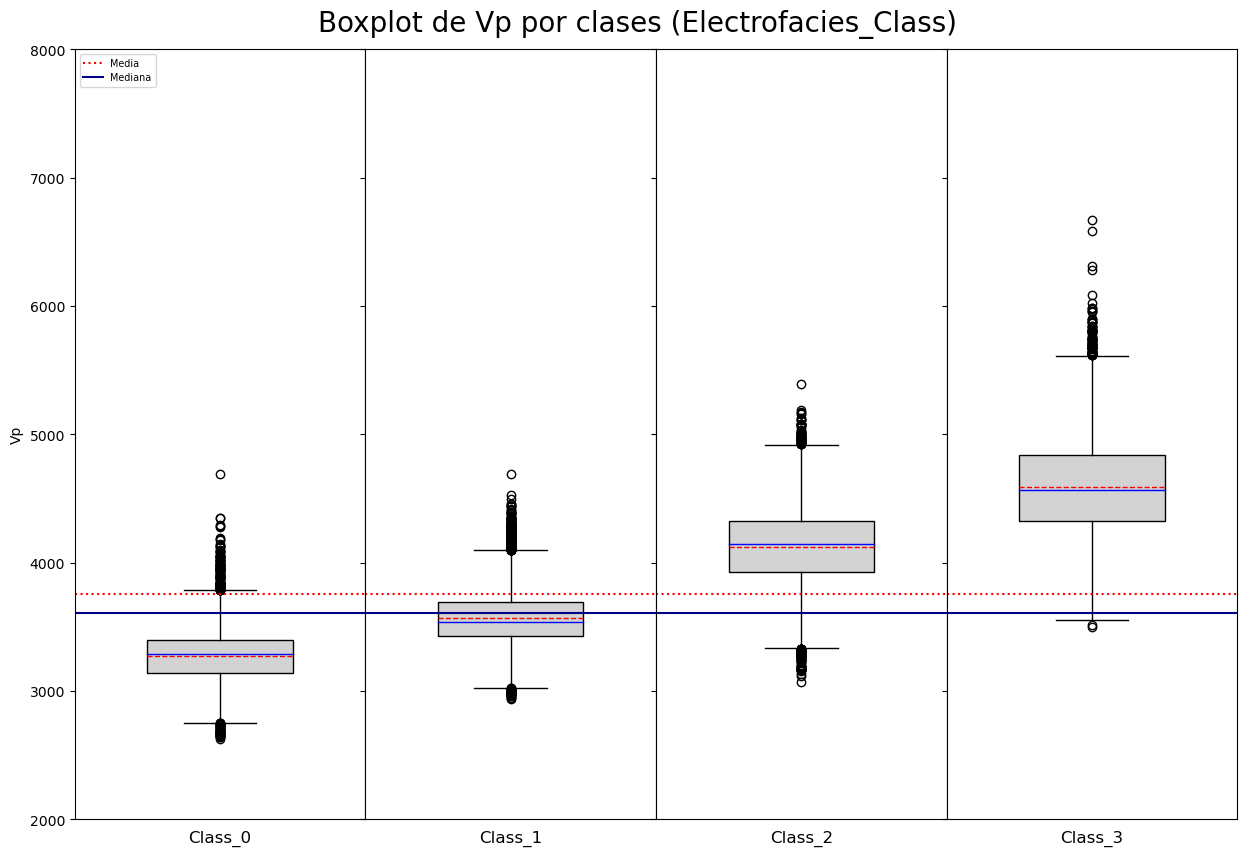

In [9]:
fig, ax = Class_Boxplots(df_CHTC,'Vp', 'Electrofacies_Class',Limits=[2000,8000], figsize=[15,10],median=True,mean=True)

In [10]:
Contar_Clases(df_CHTC, 'Electrofacies_Class').round(2)

,Electrofacies_Class,COUNT,PERCENT
0,0,15002,27.09000
1,1,19076,34.45000
2,2,14651,26.46000
3,3,6642,12.00000


**Statistics for Agua Fria wells**

In [11]:
Estadigrafos(df_CHTC[df_CHTC['Well_ID'].isin(AGF_Wells)],['Vp','Vs','RelPoisson','K','mu','E','lambda','PoroFluido']).round(2)

,Vp,Vs,RelPoisson,K,mu,E,lambda,PoroFluido
Muestras,22851.00000,22851.00000,22851.00000,22851.00000,22851.00000,22851.00000,22851.00000,22851.00000
Minimo,2760.05000,1139.44000,0.07000,13.42000,3.10000,8.75000,4.38000,0.00000
1er Cuartil,3350.19000,1616.70000,0.32000,19.34000,6.59000,17.74000,14.72000,0.06000
Mediana,3597.13000,1800.26000,0.33000,22.05000,8.29000,22.07000,16.56000,0.08000
Media,3729.54000,1867.43000,0.33000,23.88000,9.21000,24.39000,17.74000,0.08000
3er Cuartil,4111.42000,2114.22000,0.35000,27.66000,11.49000,30.35000,19.78000,0.10000
Maximo,6671.06000,3486.39000,0.42000,83.00000,32.73000,79.74000,68.44000,0.28000
Rango,3911.01000,2346.95000,0.36000,69.59000,29.62000,71.00000,64.06000,0.28000
Rango Intercuartil,761.22000,497.52000,0.03000,8.32000,4.90000,12.61000,5.06000,0.04000
Varianza,262056.75000,117559.85000,0.00000,40.27000,12.75000,81.15000,19.47000,0.00000


**Statistics for Coapechaca wells**

In [12]:
Estadigrafos(df_CHTC[df_CHTC['Well_ID'].isin(COA_Wells)],['Vp','Vs','RelPoisson','K','mu','E','lambda','PoroFluido']).round(2)

,Vp,Vs,RelPoisson,K,mu,E,lambda,PoroFluido
Muestras,32520.00000,32520.00000,32520.00000,32520.00000,32520.00000,32520.00000,32520.00000,32520.00000
Minimo,2624.37000,1057.86000,0.13000,12.48000,2.44000,6.97000,6.56000,0.00000
1er Cuartil,3388.71000,1673.22000,0.31000,19.82000,7.12000,19.06000,15.01000,0.05000
Mediana,3616.82000,1823.24000,0.33000,22.11000,8.51000,22.63000,16.43000,0.06000
Media,3780.40000,1931.74000,0.32000,24.22000,9.92000,26.12000,17.60000,0.06000
3er Cuartil,4146.90000,2191.43000,0.34000,27.64000,12.41000,32.43000,19.27000,0.08000
Maximo,5981.75000,3376.86000,0.43000,71.26000,30.85000,77.35000,59.79000,0.35000
Rango,3357.37000,2319.00000,0.30000,58.77000,28.41000,70.38000,53.23000,0.35000
Rango Intercuartil,758.19000,518.21000,0.03000,7.82000,5.29000,13.37000,4.25000,0.03000
Varianza,272863.81000,124805.13000,0.00000,40.09000,15.06000,94.58000,16.39000,0.00000


**Bivariate analysis**

In [13]:
#data = df_CHTC[Elastic_logs].copy()
#data['legend'] = df_CHTC['Electrofacies_Class']
#fig = sns.pairplot(data, hue='legend', palette='bright',diag_kind='kde', corner=True)

In [14]:
Kendall_Coeficients = []
Pearson_Coeficients = []
Spearman_Coeficients = []
for log in Elastic_logs:
    Kendall_Coeficients.append(kendalltau(df_CHTC[log],df_CHTC[Target_log])[0])
    Pearson_Coeficients.append(pearsonr(df_CHTC[log],df_CHTC[Target_log])[0])
    Spearman_Coeficients.append(spearmanr(df_CHTC[log],df_CHTC[Target_log])[0])
df_CCoefficients = pd.DataFrame([Kendall_Coeficients, Pearson_Coeficients, Spearman_Coeficients],
                                index=['Kendall','Pearson','Spearman'],
                                columns=Elastic_logs)
df_CCoefficients

,Vp,Vs,VpVs,RelPoisson,K,mu,E,lambda,IAP,IAS,RHOZ,mu_rho,lambda_rho
Kendall,-0.41857,-0.41095,0.30896,0.30896,-0.44435,-0.43187,-0.43542,-0.42850,-0.46994,-0.45047,-0.80501,-0.45047,-0.46361
Pearson,-0.57575,-0.56784,0.45628,0.42542,-0.58727,-0.57565,-0.58385,-0.54137,-0.64253,-0.62108,-0.92766,-0.59965,-0.58290
Spearman,-0.58553,-0.57379,0.44165,0.44165,-0.61872,-0.59909,-0.60353,-0.59871,-0.64691,-0.62117,-0.92594,-0.62117,-0.64088


**Spatial analysis**

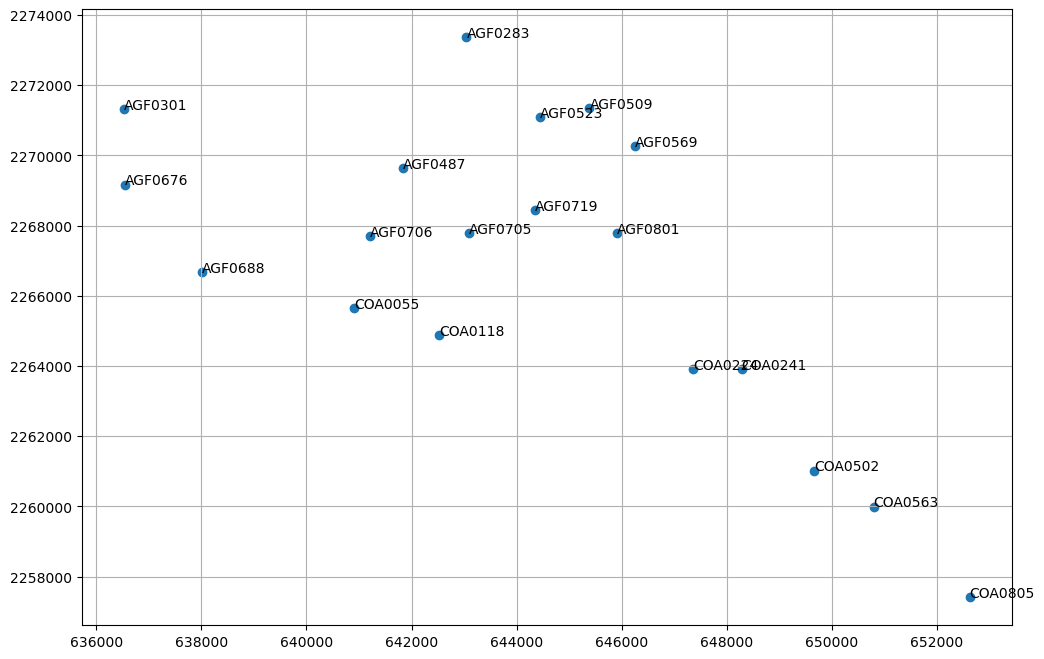

In [15]:
fig, ax = plt.subplots(figsize=[12,8])
ax.scatter(df_WellHeads['X_Coor'], df_WellHeads['Y_Coor'])
for i, txt in enumerate(df_WellHeads['Clave_']):
    ax.annotate(txt, (df_WellHeads['X_Coor'].to_list()[i], df_WellHeads['Y_Coor'].to_list()[i]))
ax.ticklabel_format(style='plain')
plt.grid()

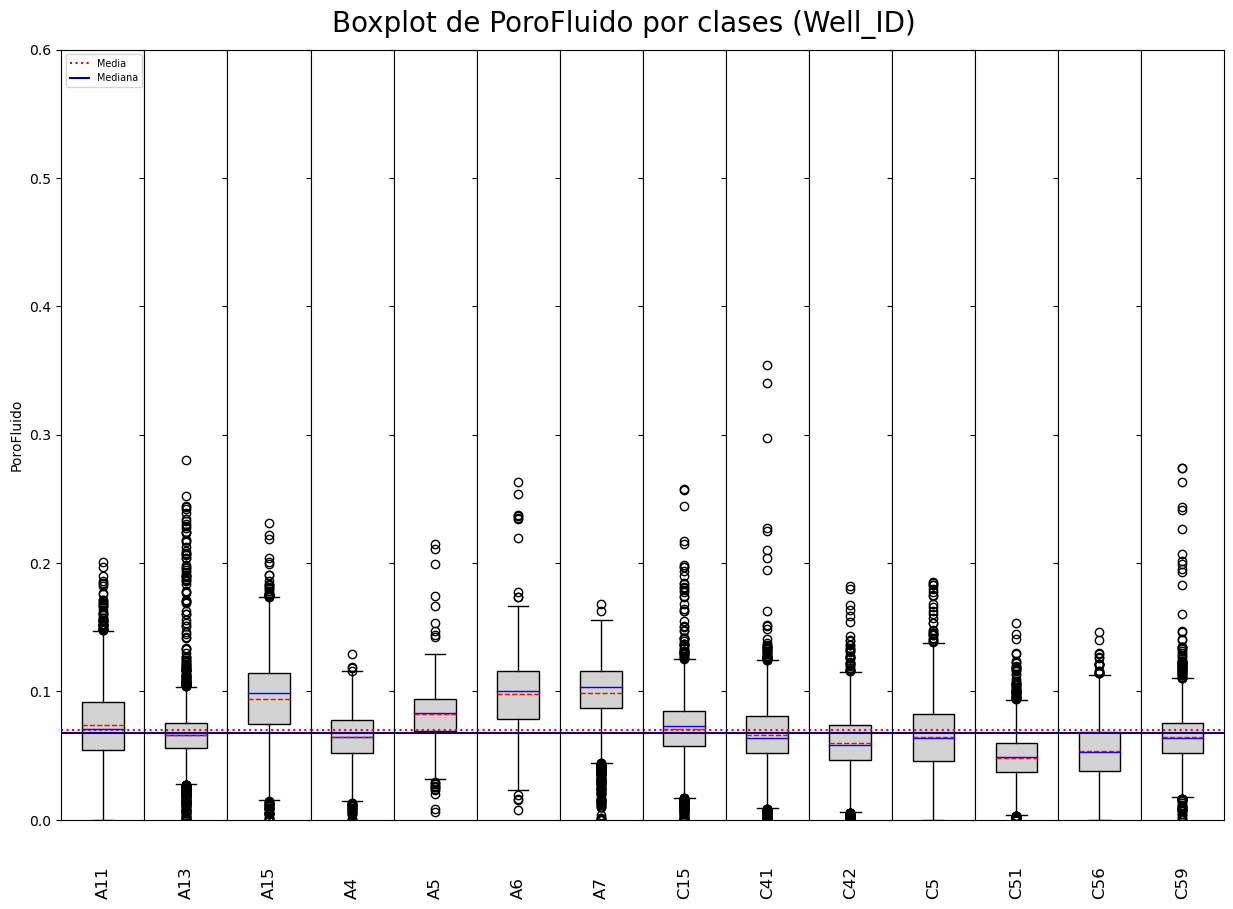

In [16]:
fig, ax = Class_Boxplots_LargeDF(df_CHTC,'PoroFluido', 'Well_ID',Limits=[0,0.6], figsize=[15,10],median=True,mean=True)
#fig.savefig('test.png')

## Feature selection.

In [17]:
f_statistics, p_values = f_regression(df_CHTC[Elastic_logs], df_CHTC['PoroFluido'])
d = {'label': df_CHTC[Elastic_logs].columns, 'f_statistics': f_statistics}
f_df = pd.DataFrame(data=d)
f_sorted = f_df.sort_values(by=['f_statistics'], ascending=False)
f_sorted;

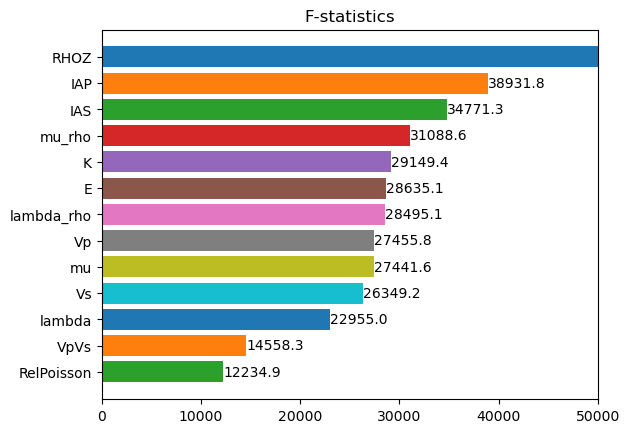

In [18]:
fig, ax = plt.subplots()
#class_plot = ax.barh(df_recortado[registros].columns, f_statistics, color=mcolors.TABLEAU_COLORS)
class_plot = ax.barh(f_sorted['label'], f_sorted['f_statistics'], color=mcolors.TABLEAU_COLORS)

ax.set_title('F-statistics')
ax.bar_label(class_plot, fmt='%.1f', label_type='edge')
ax.invert_yaxis()
ax.set_xlim(right=50000)
plt.show()

In [19]:
mutual_info = mutual_info_regression(df_CHTC[Elastic_logs], df_CHTC['PoroFluido'])
d = {'label': df_CHTC[Elastic_logs].columns, 'mutual_info': mutual_info}
mutual_info_df = pd.DataFrame(data=d)
mutual_info_sorted = mutual_info_df.sort_values(by=['mutual_info'], ascending=False)
mutual_info_sorted;

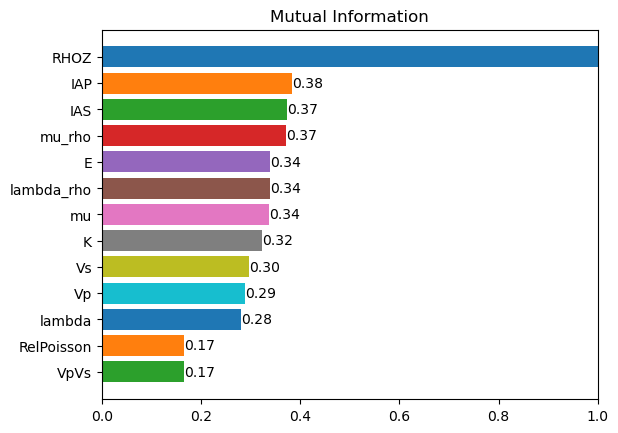

In [20]:
fig, ax = plt.subplots()
class_plot = ax.barh(mutual_info_sorted['label'], mutual_info_sorted['mutual_info'], color=mcolors.TABLEAU_COLORS)
ax.set_title('Mutual Information')
ax.bar_label(class_plot, fmt='%.2f', label_type='edge')
ax.invert_yaxis()
ax.set_xlim(right=1)
plt.show()

## Data Standarization.

Considering the objective is to approach the prediction by splitting the problem into 4 smaller tasks, the standarization was conducted for each one of the petrophysical classes separatedly.

**Global Standarization**

In [21]:
#scaler = StandardScaler()
#df_CHTC_Standard = scaler.fit_transform(df_CHTC_short[well_logs]) 
#df_standard = pd.DataFrame(df_CHTC_Standard, columns=well_logs)
#Estadigrafos(df_standard,['ECGR','AT20','AT90','RHOZ','DTCO','NPHI']).round(2)

**Well to well standarization**

In [22]:
#resultado = []
#scaler = StandardScaler()
#for Well in Prediction_Wells:
#    standarized_data = scaler.fit_transform(df_CHTC[df_CHTC['Well'] == Well][well_logs])
#    resultado = resultado + standarized_data.tolist()
#df_standard = pd.DataFrame(resultado, columns=well_logs, index=df_CHTC[df_CHTC['Well'].isin(Prediction_Wells)].index)
#Estadigrafos(df_standard,['ECGR','AT20','AT90','RHOZ','DTCO','NPHI','PHIT','PHIE','VCL']).round(2)

**Petrophysical class standarization**

The database was split into the 4 petrophysical classes predicted during the clustering analysis before data standarization.

In [23]:
df_CHTC_PC0 = df_CHTC[df_CHTC['Electrofacies_Class'] == 0]
df_CHTC_PC1 = df_CHTC[df_CHTC['Electrofacies_Class'] == 1]
df_CHTC_PC2 = df_CHTC[df_CHTC['Electrofacies_Class'] == 2]
df_CHTC_PC3 = df_CHTC[df_CHTC['Electrofacies_Class'] == 3]

In [24]:
# Petrophysical class 0
scaler_PC0 = StandardScaler()
PC_0_standard = scaler_PC0.fit_transform(df_CHTC_PC0[Elastic_logs]) 
df_CHTC_standard_temp = pd.DataFrame(PC_0_standard, columns=Elastic_logs, index=df_CHTC_PC0.index)
df_CHTC_standard_PC0 = pd.concat([df_CHTC_PC0['DEPT'],df_CHTC_PC0['Well_ID'],df_CHTC_PC0[Target_log],
                              df_CHTC_PC0['Electrofacies_Class'],df_CHTC_standard_temp], axis=1)

# Petrophysical class 1
scaler_PC1 = StandardScaler()
PC_1_standard = scaler_PC1.fit_transform(df_CHTC_PC1[Elastic_logs]) 
df_CHTC_standard_temp = pd.DataFrame(PC_1_standard, columns=Elastic_logs, index=df_CHTC_PC1.index)
df_CHTC_standard_PC1 = pd.concat([df_CHTC_PC1['DEPT'],df_CHTC_PC1['Well_ID'],df_CHTC_PC1[Target_log],
                              df_CHTC_PC1['Electrofacies_Class'],df_CHTC_standard_temp], axis=1)

# Petrophysical class 2
scaler_PC2 = StandardScaler()
PC_2_standard = scaler_PC2.fit_transform(df_CHTC_PC2[Elastic_logs]) 
df_CHTC_standard_temp = pd.DataFrame(PC_2_standard, columns=Elastic_logs, index=df_CHTC_PC2.index)
df_CHTC_standard_PC2 = pd.concat([df_CHTC_PC2['DEPT'],df_CHTC_PC2['Well_ID'],df_CHTC_PC2[Target_log],
                              df_CHTC_PC2['Electrofacies_Class'],df_CHTC_standard_temp], axis=1)

# Petrophysical class 3
scaler_PC3 = StandardScaler()
PC_3_standard = scaler_PC3.fit_transform(df_CHTC_PC3[Elastic_logs]) 
df_CHTC_standard_temp = pd.DataFrame(PC_3_standard, columns=Elastic_logs, index=df_CHTC_PC3.index)
df_CHTC_standard_PC3 = pd.concat([df_CHTC_PC3['DEPT'],df_CHTC_PC3['Well_ID'],df_CHTC_PC3[Target_log],
                              df_CHTC_PC3['Electrofacies_Class'],df_CHTC_standard_temp], axis=1)

In [25]:
# Joint of the individually standarized classses
df_CHTC_standard = pd.concat([df_CHTC_standard_PC0,df_CHTC_standard_PC1,df_CHTC_standard_PC2,df_CHTC_standard_PC3], axis=0)

**Standarized data**

The standarized dataset was split into 4 smaller ones using the petrophysical classes as a filter; this has to be done prior to preparing the train and test datasets for each one of the four Random Forests regressors that will be trained.

In [26]:
#df_CHTC_standard = pd.concat([df_CHTC['DEPT'],df_CHTC['Well'],df_CHTC[Target_log],
#                              df_CHTC['Electrofacies_Predicted'],df_standard], axis=1)
#df_CHTC_standard.dropna(axis=0, inplace=True)
#df_CHTC_standard.head(5)

In [27]:
#df_CHTC_standard_PC0 = df_CHTC_standard[df_CHTC_standard['Electrofacies_Predicted'] == 0]
#df_CHTC_standard_PC1 = df_CHTC_standard[df_CHTC_standard['Electrofacies_Predicted'] == 1]
#df_CHTC_standard_PC2 = df_CHTC_standard[df_CHTC_standard['Electrofacies_Predicted'] == 2]
#df_CHTC_standard_PC3 = df_CHTC_standard[df_CHTC_standard['Electrofacies_Predicted'] == 3]

## Data preparation.

The 19 wells of the area of interest were split into three subsets. The first of said subsets consisted of data used for the training process, the second one consisted of data needed for the testing proccess and the las one consisted of data necesary for the validating process.

**Preliminar well selection**

In order to have a small sample of wells to do the prediction, 3 wells were substracted from the dataset; these wells will be used later in the prediction section.

In [28]:
Prediction_Wells = ['C42']

In [29]:
df_CHTC_prediction = df_CHTC_standard[df_CHTC_standard['Well_ID'].isin(Prediction_Wells)]
df_CHTC_short = df_CHTC_standard[~ df_CHTC_standard['Well_ID'].isin(Prediction_Wells)]

In [30]:
df_CHTC_PC0 = df_CHTC_short[df_CHTC_short['Electrofacies_Class'] == 0]
df_CHTC_PC1 = df_CHTC_short[df_CHTC_short['Electrofacies_Class'] == 1]
df_CHTC_PC2 = df_CHTC_short[df_CHTC_short['Electrofacies_Class'] == 2]
df_CHTC_PC3 = df_CHTC_short[df_CHTC_short['Electrofacies_Class'] == 3]

**Train-Test split (whole data)**

In [31]:
## Petrophysical class 0
X_Train_0, X_Test_0, Y_Train_0, Y_Test_0 = train_test_split(
    df_CHTC_PC0[Elastic_logs], df_CHTC_PC0[Target_log], train_size=0.7, random_state=5)

## Petrophysical class 1
X_Train_1, X_Test_1, Y_Train_1, Y_Test_1 = train_test_split(
    df_CHTC_PC1[Elastic_logs], df_CHTC_PC1[Target_log], train_size=0.7, random_state=5)

## Petrophysical class 2
X_Train_2, X_Test_2, Y_Train_2, Y_Test_2 = train_test_split(
    df_CHTC_PC2[Elastic_logs], df_CHTC_PC2[Target_log], train_size=0.7, random_state=5)

## Petrophysical class 3
X_Train_3, X_Test_3, Y_Train_3, Y_Test_3 = train_test_split(
    df_CHTC_PC3[Elastic_logs], df_CHTC_PC3[Target_log], train_size=0.7, random_state=5)

## Random Forest Regressor

### Petrophysical Class 0.

In [32]:
start_time = time.time()
RF_Regressor_0 = RandomForestRegressor(n_estimators=20, max_depth=30, criterion='absolute_error', random_state=0)
RF_Regressor_0.fit(X_Train_0.to_numpy(), np.ravel(Y_Train_0.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_0.score(X_Train_0.to_numpy(), Y_Train_0.to_numpy()))

Training time  50.11070418357849 seconds
RF score de entrenamiento:  0.9644636219057888


In [33]:
Y_Test_predicted_0 = pd.DataFrame(RF_Regressor_0.predict(X_Test_0.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_0.index)

In [34]:
r2_RF_0 = metrics.r2_score(Y_Test_0, Y_Test_predicted_0)
ME_RF_0 = metrics.max_error(Y_Test_0, Y_Test_predicted_0)
MAE_RF_0 = metrics.mean_absolute_error(Y_Test_0, Y_Test_predicted_0)
MSE_RF_0 = metrics.mean_squared_error(Y_Test_0, Y_Test_predicted_0)
medianAE_RF_0 = metrics.median_absolute_error(Y_Test_0, Y_Test_predicted_0)

### Petrophysical Class 1.

In [35]:
start_time = time.time()
RF_Regressor_1 = RandomForestRegressor(n_estimators=17, max_depth=25, criterion='absolute_error', random_state=0)
RF_Regressor_1.fit(X_Train_1.to_numpy(), np.ravel(Y_Train_1.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_1.score(X_Train_1.to_numpy(), Y_Train_1.to_numpy()))

Training time  67.71185064315796 seconds
RF score de entrenamiento:  0.9447203262946998


In [36]:
Y_Test_predicted_1 = pd.DataFrame(RF_Regressor_1.predict(X_Test_1.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_1.index)

In [37]:
r2_RF_1 = metrics.r2_score(Y_Test_1, Y_Test_predicted_1)
ME_RF_1 = metrics.max_error(Y_Test_1, Y_Test_predicted_1)
MAE_RF_1 = metrics.mean_absolute_error(Y_Test_1, Y_Test_predicted_1)
MSE_RF_1 = metrics.mean_squared_error(Y_Test_1, Y_Test_predicted_1)
medianAE_RF_1 = metrics.median_absolute_error(Y_Test_1, Y_Test_predicted_1)

### Petrophysical Class 2.

In [38]:
start_time = time.time()
RF_Regressor_2 = RandomForestRegressor(n_estimators=17, max_depth=30, criterion='absolute_error', random_state=0)
RF_Regressor_2.fit(X_Train_2.to_numpy(), np.ravel(Y_Train_2.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_2.score(X_Train_2.to_numpy(), Y_Train_2.to_numpy()))

Training time  40.136621952056885 seconds
RF score de entrenamiento:  0.9827058746097328


In [39]:
Y_Test_predicted_2 = pd.DataFrame(RF_Regressor_2.predict(X_Test_2.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_2.index)

In [40]:
r2_RF_2 = metrics.r2_score(Y_Test_2, Y_Test_predicted_2)
ME_RF_2 = metrics.max_error(Y_Test_2, Y_Test_predicted_2)
MAE_RF_2 = metrics.mean_absolute_error(Y_Test_2, Y_Test_predicted_2)
MSE_RF_2 = metrics.mean_squared_error(Y_Test_2, Y_Test_predicted_2)
medianAE_RF_2 = metrics.median_absolute_error(Y_Test_2, Y_Test_predicted_2)

### Petrophysical Class 3.

In [41]:
start_time = time.time()
RF_Regressor_3 = RandomForestRegressor(n_estimators=12, max_depth=35, criterion='absolute_error', random_state=0)
RF_Regressor_3.fit(X_Train_3.to_numpy(), np.ravel(Y_Train_3.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_3.score(X_Train_3.to_numpy(), Y_Train_3.to_numpy()))

Training time  6.818758249282837 seconds
RF score de entrenamiento:  0.9878214341794682


In [42]:
Y_Test_predicted_3 = pd.DataFrame(RF_Regressor_3.predict(X_Test_3.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_3.index)

In [43]:
r2_RF_3 = metrics.r2_score(Y_Test_3, Y_Test_predicted_3)
ME_RF_3 = metrics.max_error(Y_Test_3, Y_Test_predicted_3)
MAE_RF_3 = metrics.mean_absolute_error(Y_Test_3, Y_Test_predicted_3)
MSE_RF_3 = metrics.mean_squared_error(Y_Test_3, Y_Test_predicted_3)
medianAE_RF_3 = metrics.median_absolute_error(Y_Test_3, Y_Test_predicted_3)

## Extra Trees Regressor.

### Petrophysical Class 0

In [44]:
start_time = time.time()
RFextra_Regressor_0 = ExtraTreesRegressor(n_estimators=20, max_depth=27, criterion='absolute_error', random_state=0)
RFextra_Regressor_0.fit(X_Train_0.to_numpy(), np.ravel(Y_Train_0.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_0.score(X_Train_0.to_numpy(), Y_Train_0.to_numpy()))

Training time  30.225136280059814 seconds
RF score de entrenamiento:  0.9644636219057888


In [45]:
Y_Test_predicted_0 = pd.DataFrame(RFextra_Regressor_0.predict(X_Test_0.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_0.index)

In [46]:
r2_RFextra_0 = metrics.r2_score(Y_Test_0, Y_Test_predicted_0)
ME_RFextra_0 = metrics.max_error(Y_Test_0, Y_Test_predicted_0)
MAE_RFextra_0 = metrics.mean_absolute_error(Y_Test_0, Y_Test_predicted_0)
MSE_RFextra_0 = metrics.mean_squared_error(Y_Test_0, Y_Test_predicted_0)
medianAE_RFextra_0 = metrics.median_absolute_error(Y_Test_0, Y_Test_predicted_0)

### Petrophysical Class 1

In [47]:
start_time = time.time()
RFextra_Regressor_1 = ExtraTreesRegressor(n_estimators=22, max_depth=28, criterion='absolute_error', random_state=0)
RFextra_Regressor_1.fit(X_Train_1.to_numpy(), np.ravel(Y_Train_1.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_1.score(X_Train_1.to_numpy(), Y_Train_1.to_numpy()))

Training time  48.91025996208191 seconds
RF score de entrenamiento:  0.9447203262946998


In [48]:
Y_Test_predicted_1 = pd.DataFrame(RFextra_Regressor_1.predict(X_Test_1.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_1.index)

In [49]:
r2_RFextra_1 = metrics.r2_score(Y_Test_1, Y_Test_predicted_1)
ME_RFextra_1 = metrics.max_error(Y_Test_1, Y_Test_predicted_1)
MAE_RFextra_1 = metrics.mean_absolute_error(Y_Test_1, Y_Test_predicted_1)
MSE_RFextra_1 = metrics.mean_squared_error(Y_Test_1, Y_Test_predicted_1)
medianAE_RFextra_1 = metrics.median_absolute_error(Y_Test_1, Y_Test_predicted_1)

### Petrophysical Class 2

In [50]:
start_time = time.time()
RFextra_Regressor_2 = ExtraTreesRegressor(n_estimators=12, max_depth=30, criterion='absolute_error', random_state=0)
RFextra_Regressor_2.fit(X_Train_2.to_numpy(), np.ravel(Y_Train_2.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_2.score(X_Train_2.to_numpy(), Y_Train_2.to_numpy()))

Training time  16.16272735595703 seconds
RF score de entrenamiento:  0.9827058746097328


In [51]:
Y_Test_predicted_2 = pd.DataFrame(RFextra_Regressor_2.predict(X_Test_2.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_2.index)

In [52]:
r2_RFextra_2 = metrics.r2_score(Y_Test_2, Y_Test_predicted_2)
ME_RFextra_2 = metrics.max_error(Y_Test_2, Y_Test_predicted_2)
MAE_RFextra_2 = metrics.mean_absolute_error(Y_Test_2, Y_Test_predicted_2)
MSE_RFextra_2 = metrics.mean_squared_error(Y_Test_2, Y_Test_predicted_2)
medianAE_RFextra_2 = metrics.median_absolute_error(Y_Test_2, Y_Test_predicted_2)

### Petrophysical Class 3

In [53]:
start_time = time.time()
RFextra_Regressor_3 = ExtraTreesRegressor(n_estimators=22, max_depth=15, criterion='absolute_error', random_state=0)
RFextra_Regressor_3.fit(X_Train_3.to_numpy(), np.ravel(Y_Train_3.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_3.score(X_Train_3.to_numpy(), Y_Train_3.to_numpy()))

Training time  6.5156004428863525 seconds
RF score de entrenamiento:  0.9878214341794682


In [54]:
Y_Test_predicted_3 = pd.DataFrame(RFextra_Regressor_3.predict(X_Test_3.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_3.index)

In [55]:
r2_RFextra_3 = metrics.r2_score(Y_Test_3, Y_Test_predicted_3)
ME_RFextra_3 = metrics.max_error(Y_Test_3, Y_Test_predicted_3)
MAE_RFextra_3 = metrics.mean_absolute_error(Y_Test_3, Y_Test_predicted_3)
MSE_RFextra_3 = metrics.mean_squared_error(Y_Test_3, Y_Test_predicted_3)
medianAE_RFextra_3 = metrics.median_absolute_error(Y_Test_3, Y_Test_predicted_3)

## Random Forest + AdaBoost Regressor.

### Petrophysical Class 0

In [56]:
start_time = time.time()
RFada_Regressor_0 = AdaBoostRegressor(n_estimators=27, loss='linear',learning_rate=0.1, random_state=0)
RFada_Regressor_0.fit(X_Train_0.to_numpy(), np.ravel(Y_Train_0.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_0.score(X_Train_0.to_numpy(), Y_Train_0.to_numpy()))

Training time  0.8986005783081055 seconds
RF score de entrenamiento:  0.9644636219057888


In [57]:
Y_Test_predicted_0 = pd.DataFrame(RFada_Regressor_0.predict(X_Test_0.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_0.index)

In [58]:
r2_RFada_0 = metrics.r2_score(Y_Test_0, Y_Test_predicted_0)
ME_RFada_0 = metrics.max_error(Y_Test_0, Y_Test_predicted_0)
MAE_RFada_0 = metrics.mean_absolute_error(Y_Test_0, Y_Test_predicted_0)
MSE_RFada_0 = metrics.mean_squared_error(Y_Test_0, Y_Test_predicted_0)
medianAE_RFada_0 = metrics.median_absolute_error(Y_Test_0, Y_Test_predicted_0)

### Petrophysical Class 1

In [59]:
start_time = time.time()
RFada_Regressor_1 = AdaBoostRegressor(n_estimators=27, loss='linear',learning_rate=0.1, random_state=0)
RFada_Regressor_1.fit(X_Train_1.to_numpy(), np.ravel(Y_Train_1.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_1.score(X_Train_1.to_numpy(), Y_Train_1.to_numpy()))

Training time  1.439152479171753 seconds
RF score de entrenamiento:  0.9447203262946998


In [60]:
Y_Test_predicted_1 = pd.DataFrame(RFada_Regressor_1.predict(X_Test_1.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_1.index)

In [61]:
r2_RFada_1 = metrics.r2_score(Y_Test_1, Y_Test_predicted_1)
ME_RFada_1 = metrics.max_error(Y_Test_1, Y_Test_predicted_1)
MAE_RFada_1 = metrics.mean_absolute_error(Y_Test_1, Y_Test_predicted_1)
MSE_RFada_1 = metrics.mean_squared_error(Y_Test_1, Y_Test_predicted_1)
medianAE_RFada_1 = metrics.median_absolute_error(Y_Test_1, Y_Test_predicted_1)

### Petrophysical Class 2

In [62]:
start_time = time.time()
RFada_Regressor_2 = AdaBoostRegressor(n_estimators=27, loss='linear',learning_rate=0.1, random_state=0)
RFada_Regressor_2.fit(X_Train_2.to_numpy(), np.ravel(Y_Train_2.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_2.score(X_Train_2.to_numpy(), Y_Train_2.to_numpy()))

Training time  1.0641541481018066 seconds
RF score de entrenamiento:  0.9827058746097328


In [63]:
Y_Test_predicted_2 = pd.DataFrame(RFada_Regressor_2.predict(X_Test_2.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_2.index)

In [64]:
r2_RFada_2 = metrics.r2_score(Y_Test_2, Y_Test_predicted_2)
ME_RFada_2 = metrics.max_error(Y_Test_2, Y_Test_predicted_2)
MAE_RFada_2 = metrics.mean_absolute_error(Y_Test_2, Y_Test_predicted_2)
MSE_RFada_2 = metrics.mean_squared_error(Y_Test_2, Y_Test_predicted_2)
medianAE_RFada_2 = metrics.median_absolute_error(Y_Test_2, Y_Test_predicted_2)

### Petrophysical Class 3

In [65]:
start_time = time.time()
RFada_Regressor_3 = AdaBoostRegressor(n_estimators=27, loss='linear',learning_rate=0.1, random_state=0)
RFada_Regressor_3.fit(X_Train_3.to_numpy(), np.ravel(Y_Train_3.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_3.score(X_Train_3.to_numpy(), Y_Train_3.to_numpy()))

Training time  0.49866604804992676 seconds
RF score de entrenamiento:  0.9878214341794682


In [66]:
Y_Test_predicted_3 = pd.DataFrame(RFada_Regressor_3.predict(X_Test_3.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_3.index)

In [67]:
r2_RFada_3 = metrics.r2_score(Y_Test_3, Y_Test_predicted_3)
ME_RFada_3 = metrics.max_error(Y_Test_3, Y_Test_predicted_3)
MAE_RFada_3 = metrics.mean_absolute_error(Y_Test_3, Y_Test_predicted_3)
MSE_RFada_3 = metrics.mean_squared_error(Y_Test_3, Y_Test_predicted_3)
medianAE_RFada_3 = metrics.median_absolute_error(Y_Test_3, Y_Test_predicted_3)

## Random Forest + Bagging Regressor.

### Petrophysical Class 0

In [68]:
start_time = time.time()
RFbag_Regressor_0 = BaggingRegressor(n_estimators=28, random_state=0)
RFbag_Regressor_0.fit(X_Train_0.to_numpy(), np.ravel(Y_Train_0.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_0.score(X_Train_0.to_numpy(), Y_Train_0.to_numpy()))

Training time  2.469386577606201 seconds
RF score de entrenamiento:  0.9644636219057888


In [69]:
Y_Test_predicted_0 = pd.DataFrame(RFbag_Regressor_0.predict(X_Test_0.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_0.index)

In [70]:
r2_RFbag_0 = metrics.r2_score(Y_Test_0, Y_Test_predicted_0)
ME_RFbag_0 = metrics.max_error(Y_Test_0, Y_Test_predicted_0)
MAE_RFbag_0 = metrics.mean_absolute_error(Y_Test_0, Y_Test_predicted_0)
MSE_RFbag_0 = metrics.mean_squared_error(Y_Test_0, Y_Test_predicted_0)
medianAE_RFbag_0 = metrics.median_absolute_error(Y_Test_0, Y_Test_predicted_0)

### Petrophysical Class 1

In [71]:
start_time = time.time()
RFbag_Regressor_1 = BaggingRegressor(n_estimators=19, random_state=0)
RFbag_Regressor_1.fit(X_Train_1.to_numpy(), np.ravel(Y_Train_1.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_1.score(X_Train_1.to_numpy(), Y_Train_1.to_numpy()))

Training time  1.8730230331420898 seconds
RF score de entrenamiento:  0.9447203262946998


In [72]:
Y_Test_predicted_1 = pd.DataFrame(RFbag_Regressor_1.predict(X_Test_1.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_1.index)

In [73]:
r2_RFbag_1 = metrics.r2_score(Y_Test_1, Y_Test_predicted_1)
ME_RFbag_1 = metrics.max_error(Y_Test_1, Y_Test_predicted_1)
MAE_RFbag_1 = metrics.mean_absolute_error(Y_Test_1, Y_Test_predicted_1)
MSE_RFbag_1 = metrics.mean_squared_error(Y_Test_1, Y_Test_predicted_1)
medianAE_RFbag_1 = metrics.median_absolute_error(Y_Test_1, Y_Test_predicted_1)

### Petrophysical Class 2

In [74]:
start_time = time.time()
RFbag_Regressor_2 = BaggingRegressor(n_estimators=24, random_state=0)
RFbag_Regressor_2.fit(X_Train_2.to_numpy(), np.ravel(Y_Train_2.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_2.score(X_Train_2.to_numpy(), Y_Train_2.to_numpy()))

Training time  1.7473604679107666 seconds
RF score de entrenamiento:  0.9827058746097328


In [75]:
Y_Test_predicted_2 = pd.DataFrame(RFbag_Regressor_2.predict(X_Test_2.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_2.index)

In [76]:
r2_RFbag_2 = metrics.r2_score(Y_Test_2, Y_Test_predicted_2)
ME_RFbag_2 = metrics.max_error(Y_Test_2, Y_Test_predicted_2)
MAE_RFbag_2 = metrics.mean_absolute_error(Y_Test_2, Y_Test_predicted_2)
MSE_RFbag_2 = metrics.mean_squared_error(Y_Test_2, Y_Test_predicted_2)
medianAE_RFbag_2 = metrics.median_absolute_error(Y_Test_2, Y_Test_predicted_2)

### Petrophysical Class 3

In [77]:
start_time = time.time()
RFbag_Regressor_3 = BaggingRegressor(n_estimators=23, random_state=0)
RFbag_Regressor_3.fit(X_Train_3.to_numpy(), np.ravel(Y_Train_3.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF score de entrenamiento: ', RF_Regressor_3.score(X_Train_3.to_numpy(), Y_Train_3.to_numpy()))

Training time  0.6143248081207275 seconds
RF score de entrenamiento:  0.9878214341794682


In [78]:
Y_Test_predicted_3 = pd.DataFrame(RFbag_Regressor_3.predict(X_Test_3.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_3.index)

In [79]:
r2_RFbag_3 = metrics.r2_score(Y_Test_3, Y_Test_predicted_3)
ME_RFbag_3 = metrics.max_error(Y_Test_3, Y_Test_predicted_3)
MAE_RFbag_3 = metrics.mean_absolute_error(Y_Test_3, Y_Test_predicted_3)
MSE_RFbag_3 = metrics.mean_squared_error(Y_Test_3, Y_Test_predicted_3)
medianAE_RFbag_3 = metrics.median_absolute_error(Y_Test_3, Y_Test_predicted_3)

### Metrics

### Petrophysical Class 0

In [80]:
models_RF_0 = pd.DataFrame({'Metric':['R2 Determination Coefficient','Maximum residual error','Mean absolute error',
                                    'Mean squared error','Median absolute error'],
                          'Random Forest':[r2_RF_0,ME_RF_0,MAE_RF_0,MSE_RF_0,medianAE_RF_0],
                         'Random Forest_Extra':[r2_RFextra_0,ME_RFextra_0,MAE_RFextra_0,MSE_RFextra_0,medianAE_RFextra_0],
                         'Random Forest AdaBoost':[r2_RFada_0,ME_RFada_0,MAE_RFada_0,MSE_RFada_0,medianAE_RFada_0],
                         'Random Forest Bagging':[r2_RFbag_0,ME_RFbag_0,MAE_RFbag_0,MSE_RFbag_0,medianAE_RFbag_0]})
models_RF_0

,Metric,Random Forest,Random Forest_Extra,Random Forest AdaBoost,Random Forest Bagging
0,R2 Determination Coefficient,0.77211,0.76815,0.68993,0.77856
1,Maximum residual error,0.09544,0.09344,0.09557,0.09500
2,Mean absolute error,0.00558,0.00562,0.00928,0.00550
3,Mean squared error,0.00013,0.00013,0.00018,0.00013
4,Median absolute error,0.00214,0.00205,0.00669,0.00213


### Petrophysical Class 1

In [81]:
models_RF_1 = pd.DataFrame({'Metric':['R2 Determination Coefficient','Maximum residual error','Mean absolute error',
                                    'Mean squared error','Median absolute error'],
                          'Random Forest':[r2_RF_1,ME_RF_1,MAE_RF_1,MSE_RF_1,medianAE_RF_1],
                         'Random Forest_Extra':[r2_RFextra_1,ME_RFextra_1,MAE_RFextra_1,MSE_RFextra_1,medianAE_RFextra_1],
                         'Random Forest AdaBoost':[r2_RFada_1,ME_RFada_1,MAE_RFada_1,MSE_RFada_1,medianAE_RFada_1],
                         'Random Forest Bagging':[r2_RFbag_1,ME_RFbag_1,MAE_RFbag_1,MSE_RFbag_1,medianAE_RFbag_1]})
models_RF_1

,Metric,Random Forest,Random Forest_Extra,Random Forest AdaBoost,Random Forest Bagging
0,R2 Determination Coefficient,0.67222,0.65279,0.62965,0.67418
1,Maximum residual error,0.05802,0.05860,0.04639,0.05857
2,Mean absolute error,0.00615,0.00624,0.00869,0.00607
3,Mean squared error,0.00012,0.00013,0.00013,0.00012
4,Median absolute error,0.00264,0.00255,0.00737,0.00259


### Petrophysical Class 2

In [82]:
models_RF_2 = pd.DataFrame({'Metric':['R2 Determination Coefficient','Maximum residual error','Mean absolute error',
                                    'Mean squared error','Median absolute error'],
                          'Random Forest':[r2_RF_2,ME_RF_2,MAE_RF_2,MSE_RF_2,medianAE_RF_2],
                         'Random Forest_Extra':[r2_RFextra_2,ME_RFextra_2,MAE_RFextra_2,MSE_RFextra_2,medianAE_RFextra_2],
                         'Random Forest AdaBoost':[r2_RFada_2,ME_RFada_2,MAE_RFada_2,MSE_RFada_2,medianAE_RFada_2],
                         'Random Forest Bagging':[r2_RFbag_2,ME_RFbag_2,MAE_RFbag_2,MSE_RFbag_2,medianAE_RFbag_2]})
models_RF_2

,Metric,Random Forest,Random Forest_Extra,Random Forest AdaBoost,Random Forest Bagging
0,R2 Determination Coefficient,0.89875,0.89388,0.88064,0.90245
1,Maximum residual error,0.03633,0.04211,0.03664,0.03764
2,Mean absolute error,0.00500,0.00509,0.00600,0.00488
3,Mean squared error,0.00006,0.00006,0.00007,0.00006
4,Median absolute error,0.00311,0.00315,0.00450,0.00305


### Petrophysical Class 3

In [83]:
models_RF_3 = pd.DataFrame({'Metric':['R2 Determination Coefficient','Maximum residual error','Mean absolute error',
                                    'Mean squared error','Median absolute error'],
                          'Random Forest':[r2_RF_3,ME_RF_3,MAE_RF_3,MSE_RF_3,medianAE_RF_3],
                         'Random Forest_Extra':[r2_RFextra_3,ME_RFextra_3,MAE_RFextra_3,MSE_RFextra_3,medianAE_RFextra_3],
                         'Random Forest AdaBoost':[r2_RFada_3,ME_RFada_3,MAE_RFada_3,MSE_RFada_3,medianAE_RFada_3],
                         'Random Forest Bagging':[r2_RFbag_3,ME_RFbag_3,MAE_RFbag_3,MSE_RFbag_3,medianAE_RFbag_3]})
models_RF_3

,Metric,Random Forest,Random Forest_Extra,Random Forest AdaBoost,Random Forest Bagging
0,R2 Determination Coefficient,0.92198,0.92943,0.90606,0.92467
1,Maximum residual error,0.02445,0.02843,0.02454,0.02346
2,Mean absolute error,0.00437,0.00405,0.00508,0.00427
3,Mean squared error,0.00004,0.00003,0.00004,0.00003
4,Median absolute error,0.00329,0.00293,0.00423,0.00328


## Results

In [84]:
Target_well = 'C42'

**Prediction**

In [85]:
Class_0 = df_CHTC_prediction[df_CHTC_prediction['Electrofacies_Class'] == 0][Elastic_logs]
Y_Test_predicted_0 = pd.DataFrame(RFbag_Regressor_0.predict(Class_0.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Class_0.index)

Class_1 = df_CHTC_prediction[df_CHTC_prediction['Electrofacies_Class'] == 1][Elastic_logs]
Y_Test_predicted_1 = pd.DataFrame(RFbag_Regressor_1.predict(Class_1.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Class_1.index)

Class_2 = df_CHTC_prediction[df_CHTC_prediction['Electrofacies_Class'] == 2][Elastic_logs]
Y_Test_predicted_2 = pd.DataFrame(RFbag_Regressor_2.predict(Class_2.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Class_2.index)

Class_3 = df_CHTC_prediction[df_CHTC_prediction['Electrofacies_Class'] == 3][Elastic_logs]
Y_Test_predicted_3 = pd.DataFrame(RFbag_Regressor_3.predict(Class_3.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Class_3.index)

In [86]:
Y_Test_predicted = pd.concat([Y_Test_predicted_0,Y_Test_predicted_1,Y_Test_predicted_2,Y_Test_predicted_3],axis=0)
Y_Test_predicted.sort_index(axis=0, inplace=True)

**Plots and metrics**

C:\Users\lopez\AppData\Local\Temp\ipykernel_93624\1970633636.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_temp = df_CHTC[df_CHTC['Well_ID'].isin(Prediction_Wells)].join(Y_Test_predicted)[df_CHTC_prediction['Well_ID'] == Target_well]
C:\Users\lopez\AppData\Local\Temp\ipykernel_93624\1970633636.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes[0] = plt.subplot2grid((1,2), (0,0), rowspan = 1, colspan = 1)
C:\Users\lopez\AppData\Local\Temp\ipykernel_93624\1970633636.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes[1] = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1, sharey=axes[0])


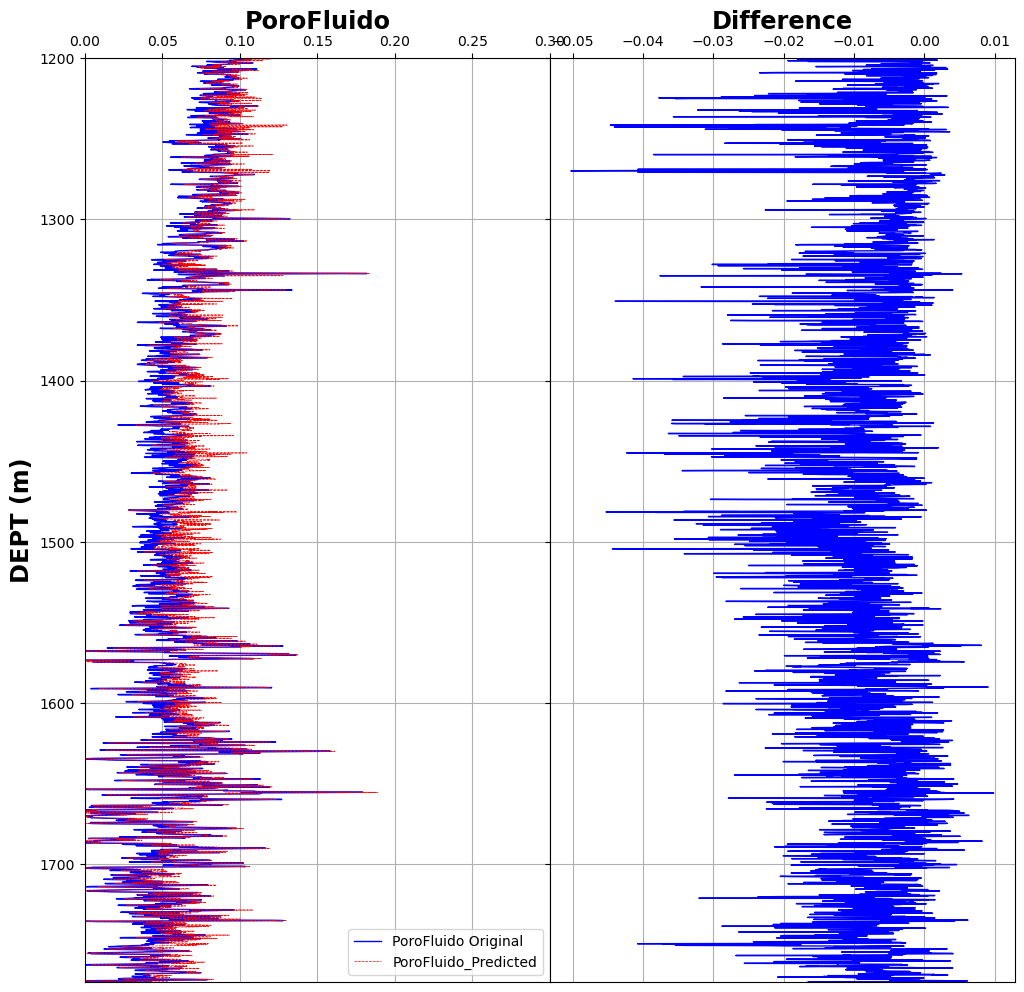

In [87]:
df_temp = df_CHTC[df_CHTC['Well_ID'].isin(Prediction_Wells)].join(Y_Test_predicted)[df_CHTC_prediction['Well_ID'] == Target_well]

## Se deine el tamaño de los carriles, titulo de la grafica y se elimina el espacio entre carriles
fig, axes = plt.subplots(1,2,figsize=[12,12],sharey=True)
#fig.suptitle('Estimación de DTSM' ,fontsize=24, x = 0.5, y = 1.02,ha = 'center')
fig.subplots_adjust(wspace = 0.0)

########  Original_log  ################
## Se definen las mallas de la curva que se va a graficar.
axes[0] = plt.subplot2grid((1,2), (0,0), rowspan = 1, colspan = 1)
## Se definen el registro que se va a graficar.
axes[0].plot(df_temp[Target_log], df_temp['DEPT'], c='b', lw=1.0, label='{} Original'.format(Target_log))
## Se establecen los limites de la grafica, tanto el registro como la profundidad.
axes[0].set_xlim(0, 0.3)
axes[0].set_ylim(math.floor(max(df_temp['DEPT'])), math.floor(min(df_temp['DEPT'])))
#axes[0].set_ylim(1500, 2000)
## Se establece la posicion de las escalas.
axes[0].xaxis.set_ticks_position("top"); axes[0].xaxis.set_label_position("top")
## Se define el titulo de cada uno de los carriles.
axes[0].set_ylabel('DEPT (m)', fontsize='xx-large',fontweight='bold')
axes[0].set_xlabel('{}'.format(Target_log), fontsize='xx-large',fontweight='bold'); axes[0].grid()

########  Regressed Log  #############
## Se definen el registro que se va a graficar.
axes[0].plot(df_temp['{}_Predicted'.format(Target_log)], df_temp['DEPT'],
             color='r',linestyle='dashed',lw=0.5,label='{}_Predicted'.format(Target_log))
#axes[0].axvline(x=df_temp['{}_Predicted'.format(Target_log)].median(), color='green', linestyle='-', label='Mediana')
#axes[0].axvline(x=df_temp['{}_Predicted'.format(Target_log)].mean(),color='r', linestyle=':', label='Media')
axes[0].legend(loc='lower right', fontsize='medium')

#######  Difference  ################
## Se definen las mallas de la curva que se va a graficar.
axes[1] = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1, sharey=axes[0])
## Se definen el registro que se va a graficar.
axes[1].plot(df_temp[Target_log] - df_temp['{}_Predicted'.format(Target_log)], df_temp['DEPT'], c='b', lw=1.0)
## Se establecen los limites de la grafica, tanto el registro como la profundidad.
#axes[1].set_xlim(math.floor(min(df_estimacion['DIF_DTSM'])), math.ceil(max(df_estimacion['DIF_DTSM'])))
## Se establece la posicion de las escalas.
axes[1].xaxis.set_ticks_position("top"); axes[1].xaxis.set_label_position("top")
#axes[1].legend(loc='lower right', fontsize='medium')
#axes[1].spines['top'].set_edgecolor('b')
#axes[1].spines["top"].set_position(('axes',1.05))
## Se define el titulo de cada uno de los carriles.
axes[1].set_xlabel('Difference', fontsize='xx-large',fontweight='bold'); axes[1].grid()
plt.setp(axes[1].get_yticklabels(), visible = False);

In [88]:
r2_RFbag_pred = metrics.r2_score(df_temp[Target_log], Y_Test_predicted)
ME_RFbag_pred = metrics.max_error(df_temp[Target_log], Y_Test_predicted)
MAE_RFbag_pred = metrics.mean_absolute_error(df_temp[Target_log], Y_Test_predicted)
MSE_RFbag_pred = metrics.mean_squared_error(df_temp[Target_log], Y_Test_predicted)
medianAE_RFbag_pred = metrics.median_absolute_error(df_temp[Target_log], Y_Test_predicted)

In [89]:
Prediction_metrics = pd.DataFrame({'Metric':['R2 Determination Coefficient','Maximum residual error','Mean absolute error',
                                    'Mean squared error','Median absolute error'],
                          Target_well:[r2_RFbag_pred,ME_RFbag_pred,MAE_RFbag_pred,MSE_RFbag_pred,medianAE_RFbag_pred]})
Prediction_metrics

,Metric,C42
0,R2 Determination Coefficient,0.76173
1,Maximum residual error,0.05024
2,Mean absolute error,0.00823
3,Mean squared error,0.00012
4,Median absolute error,0.00660


## Leave-one-out cross-validation.

Once the base predictor had been trained and validated and aiming to delve deeper into the overall performance, the leave-one-out method was conducted. Said method systematically removes one well from the sample before training and validating, this proves metrics and statistics of the performance of the algorith when small changes are made, therefore it helps to understand how robust it is.

The leave-one-out methodology was conducted by casting the code of this NoteBook into a function (the standarization, splitting, training and validating snippets) so it would work leaving one well out. The function is then inserted in a loop.

In [90]:
LOO_Wells = [[well for well in Wells if well!=Wells[i]] for i in range(len(Wells))]
Out_well = [[well for well in Wells if well==Wells[i]] for i in range(len(Wells))]
#pd.DataFrame(LOO_Wells)

In [91]:
Training_Metrics0 =[]
Training_Metrics1 =[]
Training_Metrics2 =[]
Training_Metrics3 =[]
Prediction_Metrics = []
#LOO_Wells = LOO_Wells[0:2]

In [92]:
for i in range(len(LOO_Wells)):
    one, two = RF_Batch(df_CHTC, Elastic_logs, 'PoroFluido',LOO_Wells[i])
    Training_Metrics0.append(one[0])
    Training_Metrics1.append(one[1])
    Training_Metrics2.append(one[2])
    Training_Metrics3.append(one[3])
    Prediction_Metrics.append(two)

In [93]:
Prediction_Metrics = pd.DataFrame(Prediction_Metrics, columns=
                                  ['R2 Determination Coefficient','Maximum residual error',
                                   'Mean absolute error','Mean squared error','Median absolute error'],
                                  index=pd.DataFrame(Out_well)[0])
Prediction_Metrics

,R2 Determination Coefficient,Maximum residual error,Mean absolute error,Mean squared error,Median absolute error
0,,,,,
A4,0.79695,0.04418,0.00586,0.00008,0.00383
A5,0.92313,0.02630,0.00408,0.00003,0.00337
A6,0.92693,0.11721,0.00388,0.00005,0.00312
A7,0.95736,0.05002,0.00357,0.00003,0.00261
A11,0.94537,0.03217,0.00501,0.00004,0.00433
A13,0.91776,0.04789,0.00482,0.00005,0.00320
A15,-0.63109,0.09424,0.03548,0.00147,0.03757
C5,0.92149,0.04714,0.00499,0.00005,0.00338
C15,0.96478,0.03489,0.00321,0.00002,0.00242


**LOO Statistics**

In [94]:
Estadigrafos(Prediction_Metrics,['R2 Determination Coefficient','Maximum residual error',
                                   'Mean absolute error','Mean squared error','Median absolute error'])

,R2 Determination Coefficient,Maximum residual error,Mean absolute error,Mean squared error,Median absolute error
Muestras,14.00000,14.00000,14.00000,14.00000,14.00000
Minimo,-0.63109,0.02630,0.00321,0.00002,0.00242
1er Cuartil,0.77053,0.04492,0.00416,0.00004,0.00314
Mediana,0.91963,0.05013,0.00500,0.00005,0.00337
Media,0.74037,0.05824,0.00750,0.00017,0.00608
3er Cuartil,0.92685,0.06828,0.00689,0.00010,0.00420
Maximo,0.96478,0.11721,0.03548,0.00147,0.03757
Rango,1.59586,0.09091,0.03228,0.00145,0.03515
Rango Intercuartil,0.15632,0.02336,0.00273,0.00006,0.00106
Varianza,0.18120,0.00067,0.00007,0.00000,0.00008


## Extra

In [95]:
fig, ax = Class_Boxplots_LargeDF(Prediction_Metrics,'NPHI', 'Well_ID',Limits=[0,0.6], figsize=[15,10],median=True,mean=True)

KeyError: 'Well_ID'

In [ ]:
fig, ax = plt.subplots()
#class_plot = ax.barh(df_recortado[registros].columns, f_statistic, color=mcolors.TABLEAU_COLORS)
class_plot = ax.barh(f_sorted['label'], f_sorted['f_statistic'], color=mcolors.TABLEAU_COLORS)

ax.set_title('F-statistic')
ax.bar_label(class_plot, fmt='%.1f', label_type='edge')
ax.invert_yaxis()
ax.set_xlim(right=20000)
plt.show()
#fig.savefig('F-Static.png')